In [1]:
%matplotlib inline

In [2]:
import eli5
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import data

In [3]:
data = pd.read_excel('./data/hru_params.xlsx')

feature_cols = data.columns.drop(['hru_id', 'runoff_nf']).tolist()
label_col = 'runoff_nf'

print(len(data))

1025


# Simple correlation

In [4]:
corr = data[feature_cols + [label_col]].corr(method='spearman')

Text(0,0.5,'Spearman correlation')

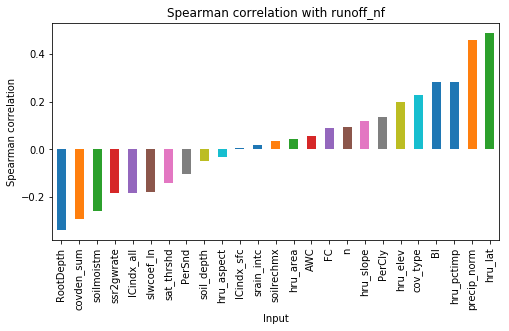

In [5]:
(
    corr
    .loc[feature_cols, label_col]
    .sort_values()
    .plot(kind='bar', figsize=(8, 4), title='Spearman correlation with {}'.format(label_col))
)
plt.xlabel('Input')
plt.ylabel('Spearman correlation')

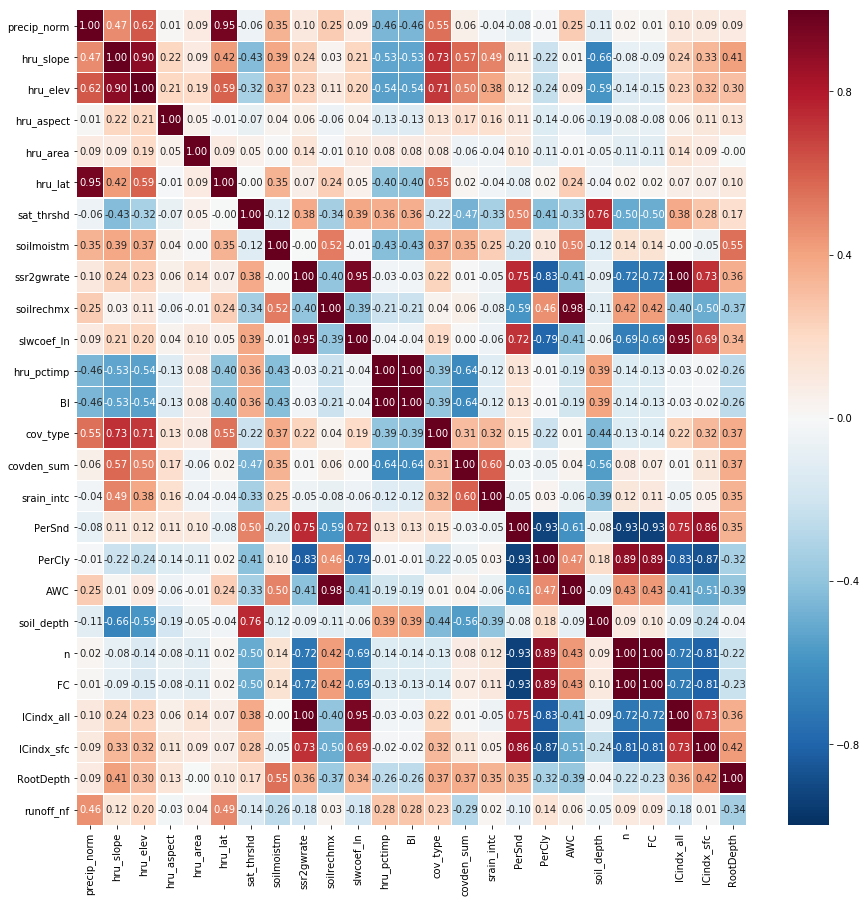

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr[feature_cols], annot=True, linewidths=.2, vmin=-1, vmax=1, ax=ax, fmt=".2f", cmap='RdBu_r')

# Build regression model

#### Split off some test data to ensure we're not overfitting

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data[feature_cols].values,
    data[label_col].values,
    test_size=0.3,
    random_state=42,
)

Iterate over min_samples sizes to evaluate overfitting

In [8]:
mse = pd.DataFrame()

print('min_samples:')
for min_samples in range(1, 40, 5):
    print(f'{min_samples},', end=' ')
    model = RandomForestRegressor(n_estimators=200, min_samples_leaf=min_samples)
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    mse = mse.append(pd.DataFrame({
        'train_error': mean_squared_error(y_train, y_pred_train),
        'test_error': mean_squared_error(y_test, y_pred_test),
    }, index=[min_samples]
    ))

min_samples:
1, 6, 11, 16, 21, 26, 31, 36, 

Test error is lower with smaller min_samples, but gap between test/train shrinks until ~10 samples. Going with that.

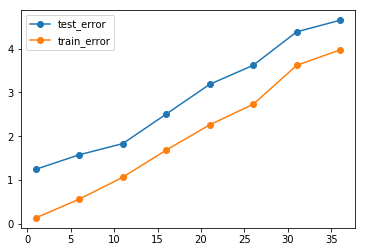

In [9]:
mse.plot(style='-o')

In [10]:
model = RandomForestRegressor(n_estimators=200, min_samples_leaf=10)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### How does the model do?

Looks like it's creating the right overall trends, but I wouldn't publish it...

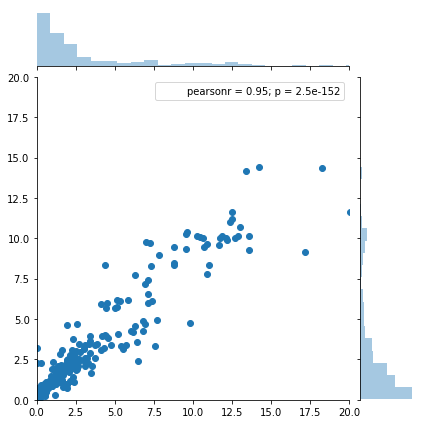

In [11]:
sns.jointplot(
    y_test, model.predict(X_test),
    xlim=(0,20), ylim=(0,20)
)

# Permuation importances (using regression model)

http://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html#eli5-permutation-importance

In [12]:
perm = eli5.sklearn.PermutationImportance(model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_cols)

Weight,Feature
0.4460 ± 0.0580,hru_elev
0.1788 ± 0.0217,covden_sum
0.1419 ± 0.0195,hru_lat
0.1101 ± 0.0518,sat_thrshd
0.0356 ± 0.0089,hru_pctimp
0.0311 ± 0.0050,BI
0.0189 ± 0.0027,precip_norm
0.0140 ± 0.0030,RootDepth
0.0109 ± 0.0104,ICindx_sfc
0.0092 ± 0.0037,soil_depth
